To start, we import the `matplotlib` library, which is essential for visualizing different aspects of our calculations, such as molecular geometry, as well as the resulting IR and Raman spectra. By setting `plt.rcParams['figure.dpi'] = 120`, we adjust the resolution of the figures to ensure they are displayed with sufficient clarity and detail.

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

As previously mentioned, we use the PLAMS Python library to interact with AMS. The code below constructs the beryllium oxide (BeO) crystal structure by defining a `Molecule` object. Individual atoms, beryllium (Be) and oxygen (O), are then added to the molecule using their respective symbols and Cartesian coordinates, which are specified in Angstroms. Next, the crystal lattice is defined as a 3x3 matrix, with dimensions also in Angstroms.

In [2]:
from scm.plams import Molecule, Atom

mol = Molecule()
mol.add_atom(Atom(symbol="Be", coords=(0.00000000, 1.55554138, 0.00070090)))
mol.add_atom(Atom(symbol="Be", coords=(1.34713836, 0.77777069, 2.18871035)))
mol.add_atom(Atom(symbol= "O", coords=(0.00000000, 1.55554138, 1.65124622)))
mol.add_atom(Atom(symbol= "O", coords=(1.34713836, 0.77777069, 3.83925567)))
mol.lattice = [[ 2.69427671, 0.00000000, 0.00000000], \
               [-1.34713836, 2.33331208, 0.00000000], \
               [ 0.00000000, 0.00000000, 4.37601889]]

To visualize the BeO crystal structure we've defined, we employ the `plot_molecule` function. This function serves as an interface to the `plot_atoms` function from the Atomic Simulation Environment (ASE), enabling us to generate graphical representations of the atomic arrangement. For a more detailed control over the generated figures, you can consult the original ASE documentation. In this particular instance, we generate three distinct views of the BeO structure by applying different rotation angles. Specifically, we create a figure with three subplots, each displaying the molecule rotated along different axes: `('15x,15y,0z')`, `('0x,90y,0z')`, and `('0x,0y,0z')`.

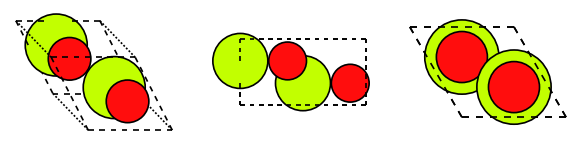

In [3]:
from scm.plams import plot_molecule

fig, ax_arr = plt.subplots(1, 3)
ax_arr[0] = plot_molecule(mol, ax=ax_arr[0], rotation=('15x,15y,0z'))
ax_arr[1] = plot_molecule(mol, ax=ax_arr[1], rotation=('0x,90y,0z'))
ax_arr[2] = plot_molecule(mol, ax=ax_arr[2], rotation=('0x,0y,0z'))

We now proceed to configure the Quantum Espresso calculation. Initially, a `Settings` object is created to store all the necessary parameters. To ensure the reliability of our vibrational spectrum, we specify a `GeometryOptimization` task, guaranteeing that our structure resides at a local energy minimum, thus avoiding contributions from imaginary frequencies. Subsequently, we explicitly request the calculation of `NormalModes` (which yields the IR spectrum) and the `Raman` spectrum within the Properties section (`s.input.ams.Properties`).

For the electronic structure calculation, we set an energy cutoff (`ecutwfc`) of `25 Ry`. While this value is intentionally low for illustrative purposes and to speed up the calculation, it is important to note that for production calculations, a cutoff of at least `40 Ry` is generally recommended. The optimal cutoff value, however, depends on the specific system being investigated. We specify a Monkhorst–Pack grid with dimensions of `4 × 4 × 3` for sampling the first Brillouin zone, aiming for relatively uniform sampling in the three directions.

Additionally, we specify the pseudopotentials required for the calculation. Due to Quantum Espresso’s limitation in supporting only Norm-Conserving (NC) and LDA-type pseudopotentials for Raman spectra calculations, which are not included in our standard pseudopotential families, we directly specify the pseudopotential files: `QE/Be.pz-mt_fhi.UPF` for beryllium and `QE/O.pz-mt_fhi.UPF` for oxygen. The pseudopotential filenames indicate the use of the Perdew-Zunger LDA functional (`pz`), the Martins-Troullier generation method (`mt`), and their origin from the FHI-aims library (`fhi`).

Finally, we instantiate an `AMSJob` object, combining the defined `Settings` and the `Molecule` object, and we assign the name `"BeO"` to the job. This job object encapsulates all the necessary information for the Quantum Espresso calculation and is ready to be executed.

In [4]:
from scm.plams import Settings, AMSJob

s = Settings()

s.input.ams.Task = "GeometryOptimization"

s.input.ams.Properties.NormalModes = "Yes"
s.input.ams.Properties.Raman = "Yes"

s.input.QuantumEspresso.System.ecutwfc = 25.0
s.input.QuantumEspresso.K_Points._h = "automatic"
s.input.QuantumEspresso.K_Points._1 = "4 4 3 0 0 0"
s.input.QuantumEspresso.Pseudopotentials.Files = [
    Settings(Label="Be", Path="QE/Be.pz-mt_fhi.UPF"),
    Settings(Label="O", Path="QE/O.pz-mt_fhi.UPF")
]

job = AMSJob(settings=s, molecule=mol, name="BeO")

The `job.get_input()` function retrieves the content of the AMS input file generated during the previous setup. This enables users to inspect the input parameters before running the Quantum Espresso calculation. Reviewing the input file can be beneficial for advanced users who seek greater control over the calculation settings.

In [5]:
print(job.get_input())

Properties
  NormalModes Yes
  Raman Yes
End

Task GeometryOptimization

System
  Atoms
             Be       0.0000000000       1.5555413800       0.0007009000
             Be       1.3471383600       0.7777706900       2.1887103500
              O       0.0000000000       1.5555413800       1.6512462200
              O       1.3471383600       0.7777706900       3.8392556700
  End
  Lattice
         2.6942767100     0.0000000000     0.0000000000
        -1.3471383600     2.3333120800     0.0000000000
         0.0000000000     0.0000000000     4.3760188900
  End
End

Engine QuantumEspresso
  K_Points automatic
     4 4 3 0 0 0
  End
  Pseudopotentials
    Files
      Label Be
      Path QE/Be.pz-mt_fhi.UPF
    End
    Files
      Label O
      Path QE/O.pz-mt_fhi.UPF
    End
  End
  System
    ecutwfc 25.0
  End
EndEngine




We call the `run()` method on the previously defined `AMSJob` object to start the Quantum Espresso calculation. This starts the execution of the job, and once it is completed, the results are stored in the results object. The output displays various stages of the job's progress, including `STARTED`, `RUNNING`, `FINISHED`, and finally, `SUCCESSFUL`, which indicates that the calculation has been completed without any errors.

In [6]:
results = job.run()

[12.03|11:39:02] JOB BeO STARTED
[12.03|11:39:02] JOB BeO RUNNING
[12.03|11:39:35] JOB BeO FINISHED
[12.03|11:39:35] JOB BeO SUCCESSFUL


The results object offers specialized functions for extracting calculated vibrational frequencies and intensities for both IR and Raman spectra. In the code below, we use the methods `get_frequencies()`, `get_ir_intensities()`, and `get_raman_intensities()` to obtain these values. Afterward, the code prints the frequencies (in cm⁻¹), IR intensities (in km/mol), and Raman intensities (in A⁴/mol) in a nice table with three columns.

In [7]:
freqs = results.get_frequencies()
ir_int = results.get_ir_intensities()
raman_int = results.get_raman_intensities()

print(f"{'freqs(cm-1)':>15} {'IR(km/mol)':>15} {'Raman(A^4/mol)':>15}")
for freq, ir, raman in zip(freqs, ir_int, raman_int):
    print(f"{freq:>15.1f} {ir:>15.3f} {raman:>15.3f}")

    freqs(cm-1)      IR(km/mol)  Raman(A^4/mol)
          250.3           0.000           0.213
          250.3           0.000           0.213
          490.8           0.000           0.000
          693.4           0.000           3.007
          693.4           0.000           3.007
          696.3        1043.853          13.503
          741.3         990.970           4.991
          741.3         990.970           4.991
          830.8           0.000           0.000


To visualize the IR spectrum, we use the `get_ir_spectrum` function, which applies broadening to the calculated absorptions in order to simulate the spectral lineshape observed in experiments. In this case, we use Lorentzian broadening with a width of 10 cm⁻¹ and focus on the spectral range from 200 to 1000 cm⁻¹. The `post_process="max_to_1"` option normalizes the spectrum by setting the maximum intensity to 1.

Then, we use matplotlib to visualize the results. We show the broadened IR spectrum as a curve (in blue) and small vertical bars (in red) to indicate the positions of the individual vibrational frequencies. Interestingly, the most prominent absorption in the spectrum results not from a single, high-intensity mode but rather from the overlap of two degenerate absorptions.

In [8]:
ir_data = results.get_ir_spectrum(broadening_type="lorentzian", broadening_width=10, min_x=200, max_x=1000, post_process="max_to_1")

fig,ax = plt.subplots()
ax.vlines(freqs, 0, len(freqs)*[ir_data[1].max()*0.05], color="r" )
ax.plot(*ir_data)
ax.set_xlabel("Frequency (cm$^{-1}$)")
ax.set_ylabel("Intensity (arb.)")
ax.set_title("BeO IR Spectrum")
plt.show()

To visualize the Raman spectrum, we adopt a similar approach as with the IR spectrum, but using the `get_raman_spectrum` function. In contrast to the IR spectrum, the most prominent absorption in the Raman spectrum originates from a single, high-intensity mode rather than from the overlap of degenerate absorptions.

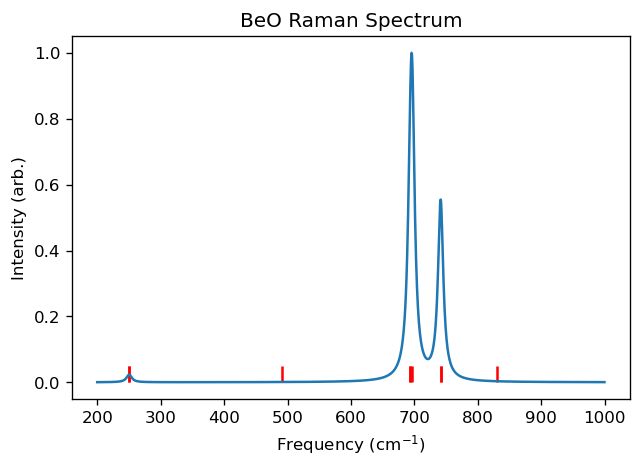

In [9]:
raman_data = results.get_raman_spectrum(broadening_type="lorentzian", broadening_width=10, min_x=200, max_x=1000, post_process="max_to_1")

fig,ax = plt.subplots()
ax.vlines(freqs, 0, len(freqs)*[raman_data[1].max()*0.05], color="r")
ax.plot(*raman_data)
ax.set_xlabel("Frequency (cm$^{-1}$)")
ax.set_ylabel("Intensity (arb.)")
ax.set_title("BeO Raman Spectrum")
plt.show()

The calculated IR and Raman spectra for beryllium oxide (BeO) can be compared to those available in [The Computational Raman Database](https://ramandb.oulu.fi/) (mpid: mp-2542). Our results are qualitatively consistent with those reported in this database. However, to reach more accurate results, it is essential to carefully optimize several parameters, such as using finer Brillouin zone sampling and a more appropriate energy cutoff.